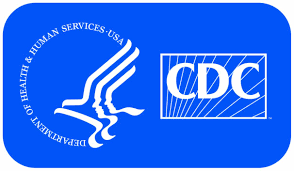
image credit: https://medworksmedia.com/cdc-logo/

# Misinformation & COVID-19:
## Prediction and Classification Project by Sarah Jack


Curtailing the dissemination of misinformation about COVID-19 is crucial to preventing the spread of unnecessary illness and death. To this end, it is paramount that the CDC understands what populations are most at risk for holding misinformed views. This project can be used by organizations like the CDC to target at-risk groups in case of another outbreak of viral illness like COVID-19. 

This project uses survey data from the American National Election Studies Exploratory Testing Survey from April 2020. The survey garnered over 3k responses to questions concerning  topics that include but are not limited to: electoral politics, social issues and matters of public health. 


This notebook aims to classify if respondents are misinformed about COVID-19 based on their opinions and demographic backgrounds. 

The target variable for the models is a COVID-19 misinformation score. I calculated the score by aggregating responses to two questions. The questions ask respondents if they believe COVID-19 was manufactured in a lab and if there was a publicly available vaccine at the time. 

I find that respondents who lean conservative or hold ideologically conservative view points tend to be the most at risk for misinformation surrounding COVID-19.

## DISCLAIMER 
The project deals with controversial topics and opinions. The findings from this project are not reflective of my own view points, opinions or ideas. Moreover, the word choice for questions and variables come from the data. 
The conclusions from this project are simply a product of the data I used (ANES 2020). Moreover, I was not asked my the CDC to create this analysis. The CDC is an example of a stakeholder who would benefit from this analysis. I am not affilated with the CDC nor the ANES.



# Set up: Import Libraries & Load in Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels as sm
from statsmodels.regression.linear_model import OLS
from sklearn.metrics import mean_squared_error as mse
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, plot_roc_curve, plot_confusion_matrix
from sklearn.metrics import log_loss, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
from xgboost import XGBClassifier
from scipy.stats import uniform
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
anes = pd.read_csv('data/anes_pilot_2020ets_csv.csv')
data = anes.copy(deep = True)

# EDA

In [3]:
#about 3k responses across 470 questions
data.shape

(3080, 470)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3080 entries, 0 to 3079
Columns: 470 entries, V1 to vidknow
dtypes: float64(3), int64(453), object(14)
memory usage: 11.0+ MB


In [5]:
data.describe()

,V1,_v1,follow,reg1,votemail1a,votemail1b,votecount,votemail2,voterid1,voterid2,...,rr_scale,white,black,namer,asian,hpi,mixed,race7,vidx,vidknow
count,3080.00000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,...,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3078.000000,3080.000000
mean,1540.50000,3798.924026,1.644156,1.290584,46.673377,39.099351,3.329221,2.751948,1.547727,3.457468,...,8.692857,0.701623,0.106169,0.005195,0.036364,0.001948,0.034091,1.785714,1.816439,0.407792
std,889.26374,10553.322567,0.876972,0.724222,42.500686,36.917557,1.093571,1.310572,0.776603,2.807707,...,5.998361,0.457620,0.308104,0.071899,0.187224,0.044101,0.282326,1.430945,1.272351,0.491504
min,1.00000,464.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,770.75000,1643.750000,1.000000,1.000000,2.000000,3.000000,3.000000,2.000000,1.000000,1.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
50%,1540.50000,2233.500000,1.000000,1.000000,88.000000,7.000000,3.000000,3.000000,1.000000,2.000000,...,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000
75%,2310.25000,3211.250000,2.000000,1.000000,88.000000,77.000000,4.000000,4.000000,2.000000,7.000000,...,11.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,1.000000
max,3080.00000,255418.000000,9.000000,4.000000,88.000000,77.000000,9.000000,9.000000,9.000000,9.000000,...,99.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000,9.000000,3.000000,1.000000


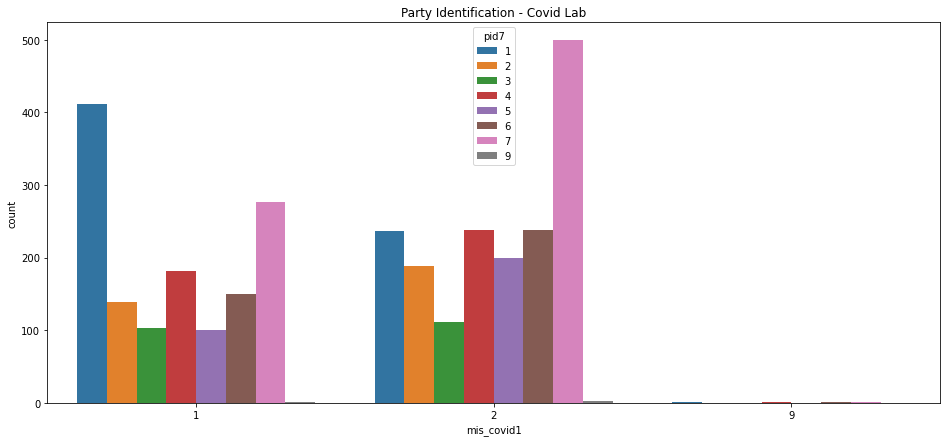

In [6]:
#let's look at some of the variables 
plt.figure(figsize=(16,7))
sns.countplot(data=data, x='mis_covid1', hue='pid7')
plt.title('Party Identification - Covid Lab');

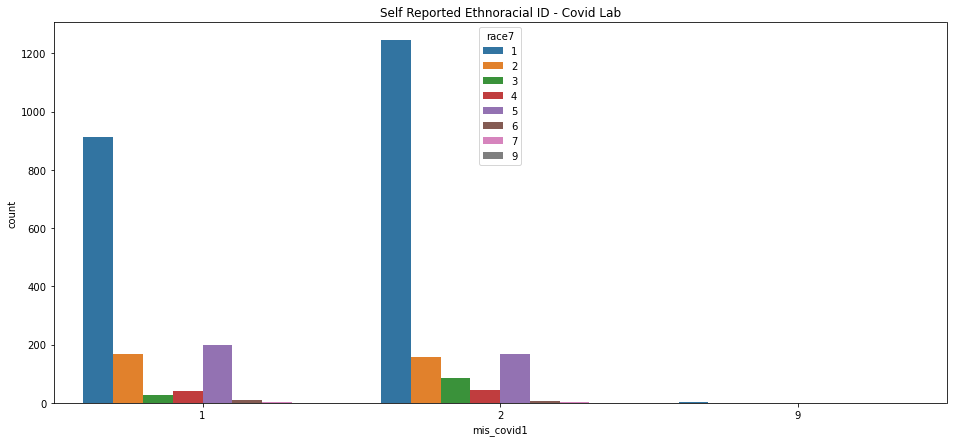

In [7]:
plt.figure(figsize=(16,7))
sns.countplot(data=data, x='mis_covid1', hue='race7')
plt.title('Self Reported Ethnoracial ID - Covid Lab');
#1=White 

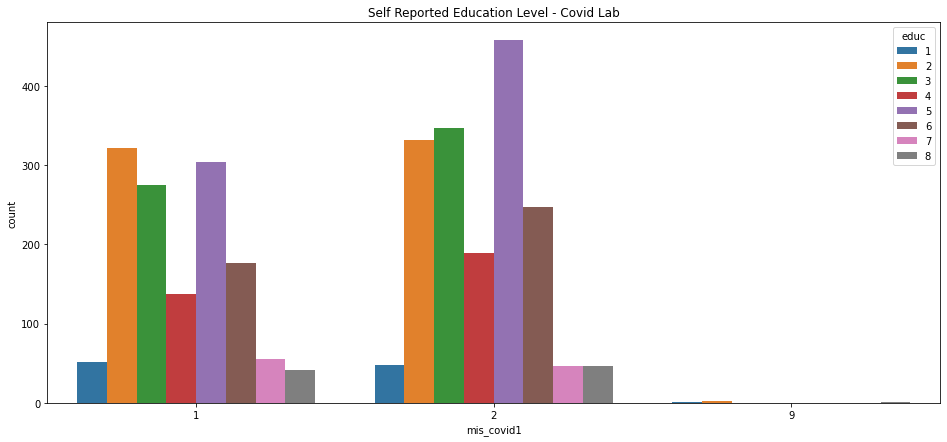

In [8]:
plt.figure(figsize=(16,7))
sns.countplot(data=data, x='mis_covid1', hue='educ')
plt.title('Self Reported Education Level - Covid Lab');
#5 = BA (college completed)

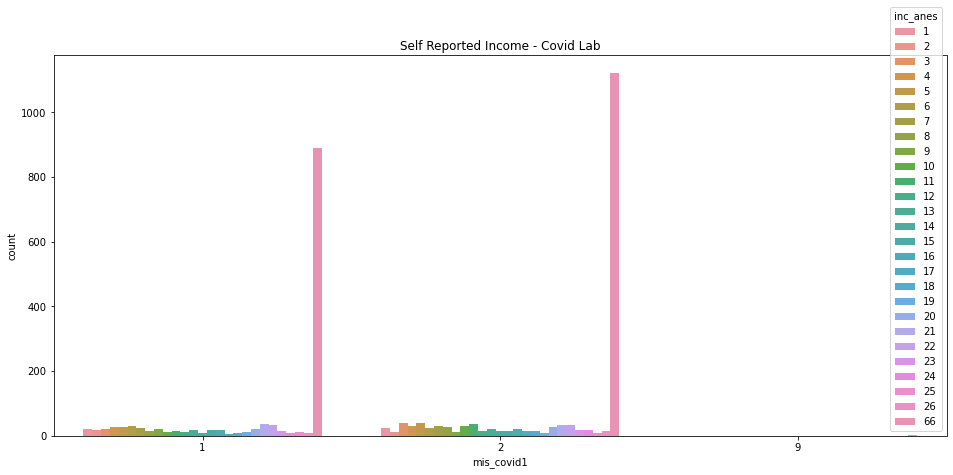

In [9]:
plt.figure(figsize=(16,7))
sns.countplot(data=data, x='mis_covid1', hue='inc_anes')
plt.title('Self Reported Income - Covid Lab');

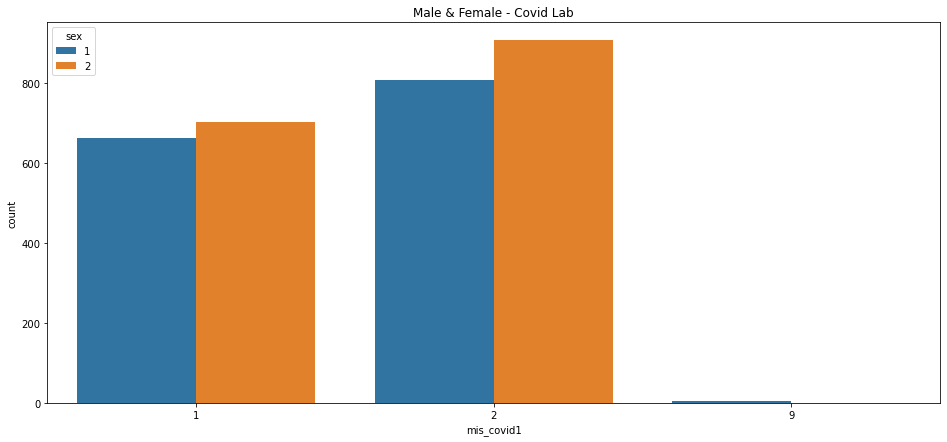

In [10]:
plt.figure(figsize=(16,7))
sns.countplot(data=data, x='mis_covid1', hue='sex')
plt.title('Male & Female - Covid Lab');

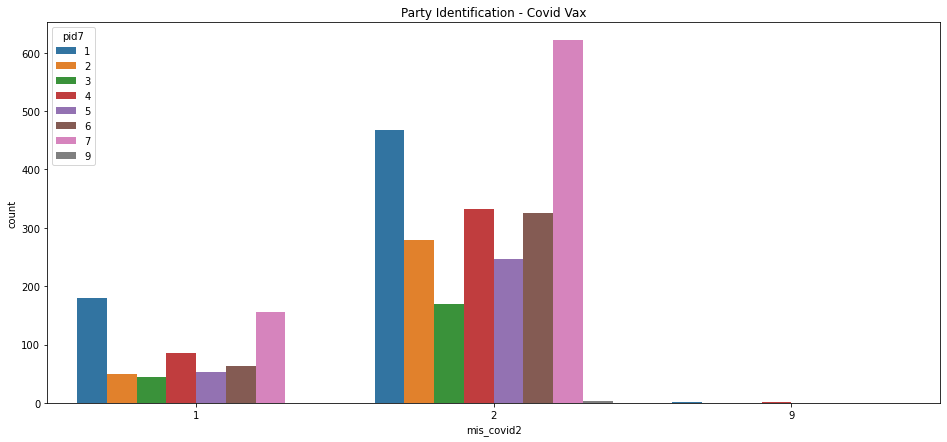

In [11]:
plt.figure(figsize=(16,7))
sns.countplot(data=data, x='mis_covid2', hue='pid7')
plt.title('Party Identification - Covid Vax');

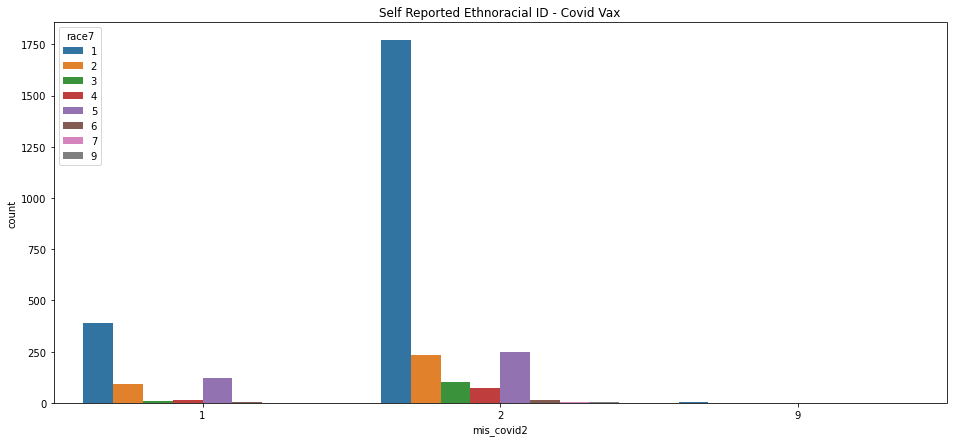

In [12]:
plt.figure(figsize=(16,7))
sns.countplot(data=data, x='mis_covid2', hue='race7')
plt.title('Self Reported Ethnoracial ID - Covid Vax');
#1=White 

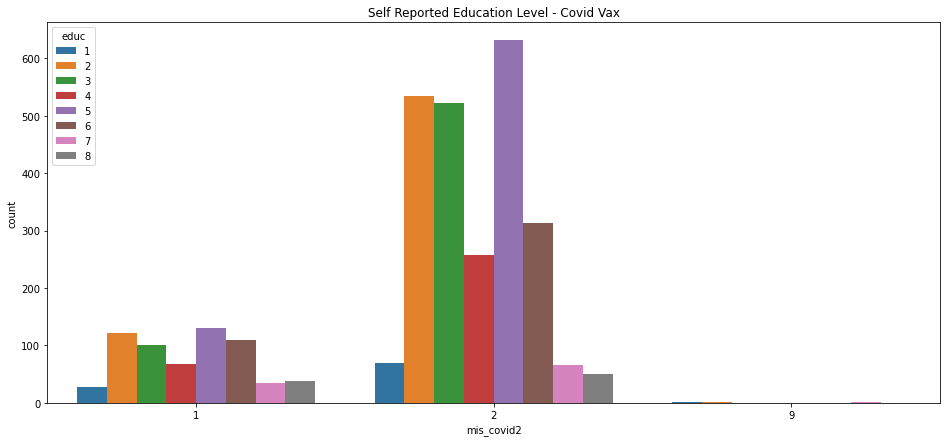

In [13]:
plt.figure(figsize=(16,7))
sns.countplot(data=data, x='mis_covid2', hue='educ')
plt.title('Self Reported Education Level - Covid Vax');
#5 = BA (college completed)

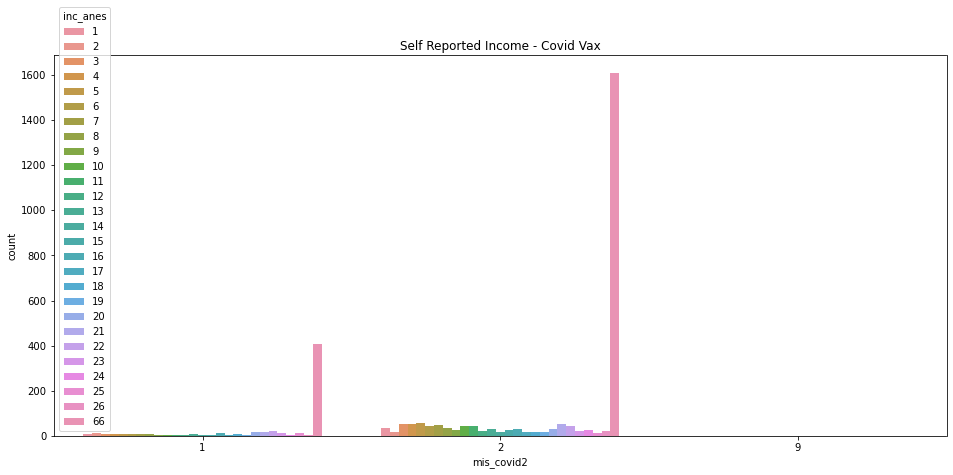

In [14]:
plt.figure(figsize=(16,7))
sns.countplot(data=data, x='mis_covid2', hue='inc_anes')
plt.title('Self Reported Income - Covid Vax');

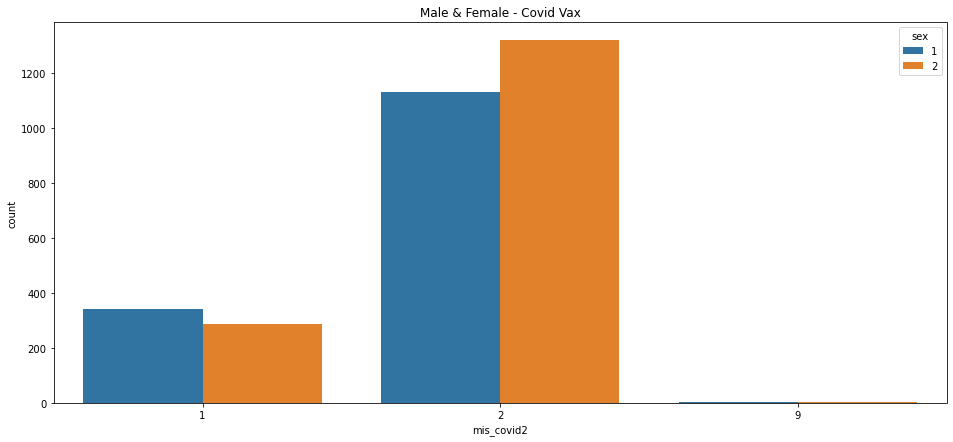

In [15]:
plt.figure(figsize=(16,7))
sns.countplot(data=data, x='mis_covid2', hue='sex')
plt.title('Male & Female - Covid Vax');

Looks like the data is pretty imbalanced demographically speaking, the main takeaway from the EDA is that party ID might be linked to holding misinformed views.

# Data Cleaning

## Dropping Irrelevant Columns 
There are 460 columns, not all of which are necessary. The first 9 columns contain metadata about the survey and survey collection method. This includes information like what browser the respondent used to take the survey, the version of that browser, which day in the week the respondent completed the survey on, etc. This information is not pertinant for my analysis. 

I elected to drop a number of columns that contain answers for questions that survyors asked based on the self-reported ethnoracial identity of the respondent. Because the answers for these questions are specific to each respondent, they can not be generalized across the dataframe. 

I also removed a number of demographic variables. This survey contains mulitple variables for political party identification and ethnoracial self-identification. This level of repition was unnecessary for the scope of this project. 

I dropped questions the surveyors used as check-points to make sure respondents were filling out the survey correctly. An example of this is "check" which asked respondents to click a certain box so that the surveyors could be sure the respondent's screen was working. Another meta-data question asked respondents if they have ever been attacked by a shark. Questions like these allow surveyors to weed out joke responses. 

In [16]:
#look at all the column names
#for col in data.columns:
   # print(col)

In [17]:
# dropping irrelevant columns 
data.drop(inplace=True, columns=[ 'votemail1b', 'V1', 'StartDate', 'EndDate', '_v1', 'RecordedDate', 
                                 'ResponseId','qmetadata_Browser', 'qmetadata_Version', '_v2', 
                                 'qmetadata_Resolution', 'check','relig1_11_TEXT', 'mauga', 'pk_cjus', 
                                 'pk_germ', 'ethnic1', 'ethnic2', 'ethnic3', 'mixed', 'hpi', 'asian', 'namer',
                                'black', 'white', 'race1_hpi', 'race1_asian', 'race1_namer', 'race1_black', 'race1_white',
                                'hispanicr', 'nonhispanic_white', 'hispanic_white', 'hispanic', 'pid2r', 'pk_index',
                                'survexp1', 'survexp2', 'dejavu', 'surv_comp', 'RAND_INC', 'XCONTACT', 'XFORGIVE', 'FEEDBACK_GROUP',
                                'INSTRUCTION_GROUP', 'form', 'serious', 'admit', 'geer1896', 'pk_sen', 'pk_spend', 'expshark',
                                'inc_cps', 'inc_cpsmod', 'marital2', 'whites_1', 'whites_2', 'whites_3',
                                'whites_4', 'whites_5', 'whites_6', 'whites_7', 'blacks_1', 'blacks_2', 'blacks_3',
                                'blacks_4', 'blacks_5', 'blacks_6', 'blacks_7', 'hisp_1', 'hisp_2', 'hisp_3',
                                'hisp_4', 'hisp_5', 'hisp_6', 'hisp_7', 'asians_1', 'asians_2', 'asians_3', 'asians_4',
                                'asians_5', 'asians_6','asians_7', 'survexp1', 'survexp2', 'dejavu', 'citizen1', 'citizen2',
                                'particip_count', 'pk_mauga_correct', 'pk_germ_correct', 'pk_cjus_correct', 'pk_sen_correct',
                                'pk_spend_correct', 'pk_cjus_correctb', 'pk_index', 'pidstr1_dr', 'pidstr1_ind', 'pidstr2_dr',
                                 'pidstr2_ind','pidstr3_dr', 'pidstr3_ind', 'pid7str', 'hispanic', 'hispanic_white', 'nonhispanic_white',
                                'hispanicr', 'race1_white', 'race1_black', 'race1_namer', 'race1_hpi', 'white', 'black',
                                'namer', 'asian', 'hpi', 'mixed'])

In [18]:
#check shape of data after dropping
data.shape

(3080, 371)

## Addressing Null Values
Because not every respondent answers every question, there are a fair amount of missing or null values. In order to keep the intgrity of my data intact I use a mix of approaches to address null and missing values. I have enough responses to simply drop columns with null values. However, there are multiple placee holder values for missing responses. Below I go through each placeholder value, replace it with a universal numpy NaN and then impute those NaN values with the median value of its respective column using SimpleImputer.

In [19]:
data.isna().sum()

follow        0
reg1          0
votemail1a    0
votecount     0
votemail2     0
             ..
pid7          0
rr_scale      0
race7         0
vidx          2
vidknow       0
Length: 371, dtype: int64

In [20]:
data.dropna(inplace=True)

In [21]:
data.shape

(3078, 371)

In [22]:
#dropping the 2 non responses for the covid questions 
data.drop(data[data['mis_covid1'] == 9].index, inplace=True)

In [23]:
data.drop(data[data['mis_covid2'] == 9].index, inplace=True)

In [24]:
#dropping the placeholder values and replacing with NaN
data_6 = ['pidstr',  'pidlean', 'pidstr1', 'pidstr2', 'pidstr3', 'relig2a',
     'att2', 'att3', 'fundmt1', 'fundmt2', 'whitejob', 'femid2_fem', 'femid2_anti',
     'femid2_nei', 'callout3a','callout3b','viol3_dems', 'viol3_reps', 'viol3_both']
for column in data_6:
    data[column].replace(6, np.nan, inplace=True)

In [25]:
#dropping the placeholder values and replacing with NaN
data_9 = ['follow', 'votemail2', 'voterid1', 'voterid2', 'vote16', 'hopeful', 'worried', 'irritated', 'talk3', 
      'primaryvote', 'vote20jb', 'vote20bs', 'richpoor2', 'lcd', 'lcr', 'freemkt1a',
     'freemkt1b', 'govsize1a', 'govsize1b', 'ineqinc1a', 'antirelig1',
     'antirelig2', 'racist1','racist2', 'immignum', 'wall7', 'pathway', 
     'return', 'open', 'affact', 'hlthcare1', 'hlthcare2', 'covid1', 'covid2',
     'covid_elect', 'abort1', 'abort_imp', 'abort2', 'gayadopt', 'transmilit1a',
     'harass', 'diversity7', 'experts', 'science', 'exphelp', 'excessive',
     'compro1', 'compro2', 'pcorrect', 'selfcensor', 'childrear1', 'childrear2',
     'childrear3', 'rural2', 'rural3', 'rural4', 'conf_covid1', 'conf_covid2', 'impeach1', 'impeach2', 'pid1r', 
     'pidstr', 'pidlean', 'pidstr1', 'pidstr2', 'pidstr3', 'rr1', 'rr2',
     'rr3', 'rr4', 'relig2b', 'att1', 'att2', 'att3', 'fundmt1', 'fundmt2',
     'impact1', 'impact2', 'impact3', 'impact4', 'impact5', 'impact7', 'impact8',
     'impact9', 'whitejob', 'femid1a', 'femid1b', 'femid2_fem', 'knowtran1',
     'knowtran2_1', 'knowtran2_2', 'knowtran2_3', 'knowtran2_4', 'knowtran2_5',
     'knowtran2_6', 'knowgay1', 'knowgay2_1', 'knowgay2_2', 'knowgay2_3', 'knowgay2_4',
     'knowgay2_5', 'knowgay2_6', 'stress1', 'stress2', 'stress3', 'stress4',
     'depress1', 'depress2', 'depress3', 'depress4', 'depress5', 'callout1',
     'speech1', 'callout2', 'speech2', 'divmoral', 'forgive3', 'moralsup1',
     'duepro3', 'moralcert3', 'forgive5', 'intelsup1', 'moralcert1', 'duepro4',
     'moralcert6', 'forgive4', 'moralcert2', 'duepro1', 'callout3a','callout3b',
     'moralsup2', 'duepro2', 'intelsup2', 'duepro5', 'moralcert4', 'forgive6', 
     'moralcert5', 'link_bla','link_his', 'link_asi','link_whi', 'link_hpi', 'link_nat',
     'selfmon1', 'selfmon2', 'selfmon3', 'selfmon4', 'selfmon5', 'selfmon6', 'home_cps',
     'viol3_dems', 'viol3_reps', 'viol1', 'viol2a', 'viol2b', 'exptravel_ever', 
     'exphomesch', 'expconvert', 'expholiday', 'exparrest', 'exppubasst', 'expfight',
     'expavoid', 'callout_social', 'callout_person', 'expknowimmig', 'expbuyus',
     'expretire', 'expknowpris', 'marital1', 'home_ownership', 'vote20turnoutjb', 'pid7',
     'race7', 'taxecon']
for column in data_9: 
    data[column].replace(9, np.nan, inplace=True)


In [26]:
#dropping the placeholder values and replacing with NaN
data_77 = ['healthcarepres7', 'dtleader2', 'jbleader2', 
     'bsleader2', 'billtax2', 'guarinc2', 'freemkt2', 'freemkt3',
     'govsize2', 'govsize3', 'regulate2', 'strpres1b', 'transmilit1b',
     'freecol2', 'loans2']
for column in data_77: 
    data[column].replace(77, np.nan, inplace=True)

In [27]:
#dropping the placeholder values and replacing with NaN
data_8 = ['turnout16a', 'turnout16a1', 'freemkt1a', 'freemkt1b',
     'govsize1a', 'govsize1b', 'antirelig1', 'antirelig2', 'racist1',
     'racist2', 'transmilit1a', 'pcorrect', 'selfcensor', 'relig2a',
     'femid1a', 'callout1', 'speech1', 'callout2', 'speech2', 'divmoral',
     'forgive3', 'moralsup1', 'duepro3', 'moralcert3', 'forgive5','intelsup1', 
     'moralcert1', 'duepro4', 'moralcert6', 'forgive4', 'moralcert2', 'duepro1',
     'callout3a','callout3b', 'moralsup2', 'duepro2', 'intelsup2', 'duepro5',
     'moralcert4', 'forgive6', 'moralcert5', 'home_anes', 'viol2a']
for column in data_8:
    data[column].replace(8, np.nan, inplace=True)

In [28]:
#dropping the placeholder values and replacing with NaN
data_7 = ['turnout16b', 'relig2b', 'femid1b', 'stress1', 'stress2', 'stress3',
     'stress4', 'depress1', 'depress2', 'depress3', 'depress4', 'depress5', 
     'link_bla','link_his','link_asi','link_whi', 'link_hpi', 'link_nat',
     'selfmon1', 'selfmon2', 'selfmon3', 'selfmon4', 'selfmon5', 'selfmon6',
     'home_cps', 'viol2b']
for column in data_7:
    data[column].replace(7, np.nan, inplace=True)

In [29]:
#dropping the placeholder values and replacing with NaN
data_99 = ['apppres7', 'frnpres7', 'immpres7', 'econpres7', 'healthcarepres7', 
     'dtcares', 'dtdignif', 'dtauth', 'dtdiv', 'dtknow', 'jbleader1',
     'jbleader2', 'jbcares', 'jbdignif', 'jbhonest', 'jbauth', 'jbdiv',
     'jbknow', 'bsleader1', 'bsleader2', 'bscares', 'bsdignif', 'bshonest',
     'bsauth', 'bsdiv', 'bsknow', 'freemkt2', 'freemkt3', 'govsize2', 'govsize3',
           'forgive1a', 'forgive1b','forgive2b','finworry', 'confecon', 'taxecon', 
     'regulate2', 'strpres1b', 'tol_rally', 'tol_pres', 'tol_teach',
     'transmilit1b', 'freecol2', 'forgive2a']
for column in data_99:
    data[column].replace(99, np.nan, inplace=True)

In [30]:
#dropping the placeholder values and replacing with NaN
data_66 = ['freemkt2', 'freemkt3', 'govsize2', 'govsize3', 
     'facebook1', 'twitter1', 'forgive1a', 'forgive1b', 'forgive2a',
     'forgive2b', 'inc_anes']
for column in data_66: 
    data[column].replace(66, np.nan, inplace=True)

In [31]:
#imputing the median 
imp=SimpleImputer(missing_values= np.nan)
data_clean = pd.DataFrame(imp.fit_transform(data))
data_clean.columns = data.columns
data_clean.index = data.index 

In [32]:
#sanity check
print(f'shape of cleaned data: {data_clean.shape}')
print(f'shape of uncleaned data: {data.shape}')

shape of cleaned data: (3072, 371)
shape of uncleaned data: (3072, 371)


# Target Variable 
Below I construct my target variable - a covid misinformation score - called "covid_mis_score". When this variable is a 0, it means the respondent is correctly informed. A 1 designates the respondent is misinformed about COVID-19. 

This variable combines the responses from two questions that ask about COVID-19. 


Further information about "mis_covid1" and "mis_covid2" can be found on page 47 in "anes_codebook.pdf" and page 25 in "anes_questions.pdf". 


"mis_covid1" asks: 
    
      "Which of these two statements do you think is most likely to be 
      true?
      
        _The coronavirus (COVID-19) was developed intentionally in a
        lab 
        
        _The coronavirus (COVID-19) was not developed intentionally in 
        a lab" 

Respondents that answered that COVID-19 was intentionally made in a lab are classified as misinformed.



"mis_covid2" asks:
    
        "Which of these two statements do you think is most likely to be 
      true?
      
        _Currently, there is a vaccine for the coronavirus (COVID-19)  
        
        _Currently, there is not a vaccine for the coronavirus(COVID-19)"
        
Respondents who  answered there was a vaccine are classified as misinformed. Note that at the time of this survey (April 10-18th 2020, there was no publicly available vaccine). 

I'll be using recall as my evaluation metric because I care more about flagging someone as positive, or misinformed when they are already informed than to flag them as informed when they are not. It is not costly to deliver correct information to someone who is already informed. 
   

In [33]:
data_clean.rename(columns={"mis_covid1": 'covid_lab'}, inplace = True)
data_clean.rename(columns={"mis_covid2": 'covid_vax'}, inplace = True)
data_clean.covid_lab.replace((2,1), (0,1), inplace=True)
data_clean.covid_vax.replace((2,1), (0,1), inplace=True)
data_clean['covid_mis_score'] = data_clean['covid_lab'] + data_clean['covid_vax']
data_clean.drop(inplace=True, columns=['covid_lab', 'covid_vax'])

In [34]:
#i want a binary classificationn problem: one is either misinformed or informed, so I'll need to change this
data_clean['covid_mis_score'].value_counts()

0.0    1577
1.0    1002
2.0     493
Name: covid_mis_score, dtype: int64

In [35]:
#making target variable binary
data_clean.loc[data_clean['covid_mis_score']==2, 'covid_mis_score']=1

In [36]:
#much better!
data_clean['covid_mis_score'].value_counts()

0.0    1577
1.0    1495
Name: covid_mis_score, dtype: int64

# Model 1: Baseline Model 
I have completed some of the initial preprocessing. Now I can look for any relationships in the data through modeling. First comes a dummy classifier. I can use this baseline model for comparison in my other, more complicated models.

In [37]:
#train test split 
X = data_clean.drop(['covid_mis_score'],axis=1)
y = data_clean['covid_mis_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [38]:
dummy_model = DummyClassifier(strategy="most_frequent")
dummy_model.fit(X_train, y_train)
dummy_model.predict(X_train)
dummy_model.score(X_train, y_train)

0.5217745217745218

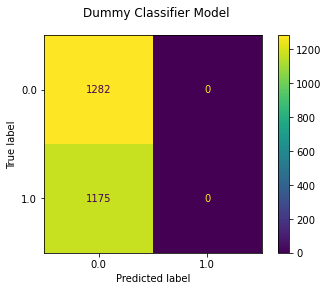

In [39]:
#confusion matrix for dummy classifer 

fig, ax = plt.subplots()

fig.suptitle("Dummy Classifier Model")

plot_confusion_matrix(dummy_model, X_train, y_train, ax=ax, values_format='');

As expected, the baseline/dummy model simply predicted the majority class. The model is basically as good as a coin toss. Let's try a simple logistic regression.

# Model 2: Simple Logistic Regression

In [40]:
#scaling data for a simple logistic regression 
scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train)
X_test_scaled = scale.transform(X_test)

simple_log_model = LogisticRegression(random_state=42)
simple_log_model.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42)

In [41]:
# looking at predictiings 
y_pred_train = simple_log_model.predict(X_train_scaled)
y_pred_test = simple_log_model.predict(X_test_scaled)

print(f"Train Recall Score: {recall_score(y_train, y_pred_train, average='weighted')}")
print(f"Test Recall Score: {recall_score(y_test, y_pred_test, average='weighted')}")

Train Recall Score: 0.7973137973137974
Test Recall Score: 0.6878048780487804


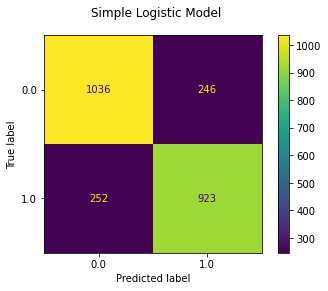

In [42]:
fig, ax = plt.subplots()

fig.suptitle("Simple Logistic Model")

plot_confusion_matrix(simple_log_model, X_train_scaled, y_train, ax=ax, values_format='');

The simple logistic model is much better! But we can improve that. Let's look into what features are most important to see if that helps improve the recall score.

# Feature Importance Algorithms
source code: Rahul Agarwal, Towards Data Science "The Five Feature Selection Algorithms Every Data Scientist Should Know"

In [43]:
features = data_clean.columns
traindf = pd.DataFrame(data_clean, columns=features)
y = traindf['covid_mis_score']
X = traindf.copy()
del X['covid_mis_score']

In [44]:
feature_name = list(X.columns)
# no of maximum features we need to select
num_feats=100

In [45]:
# pearson corr
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X, y,num_feats)
print(str(len(cor_feature)), 'selected features')

100 selected features


In [46]:
#chi squared
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

100 selected features


In [47]:
#recursive feature elimination
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(random_state=42), n_features_to_select=num_feats, step=10, verbose=5)
rfe_selector.fit(X_norm, y)

Fitting estimator with 369 features.
Fitting estimator with 359 features.
Fitting estimator with 349 features.
Fitting estimator with 339 features.
Fitting estimator with 329 features.
Fitting estimator with 319 features.
Fitting estimator with 309 features.
Fitting estimator with 299 features.
Fitting estimator with 289 features.
Fitting estimator with 279 features.
Fitting estimator with 269 features.
Fitting estimator with 259 features.
Fitting estimator with 249 features.
Fitting estimator with 239 features.
Fitting estimator with 229 features.
Fitting estimator with 219 features.
Fitting estimator with 209 features.
Fitting estimator with 199 features.
Fitting estimator with 189 features.
Fitting estimator with 179 features.
Fitting estimator with 169 features.
Fitting estimator with 159 features.
Fitting estimator with 149 features.
Fitting estimator with 139 features.
Fitting estimator with 129 features.
Fitting estimator with 119 features.
Fitting estimator with 109 features.


RFE(estimator=LogisticRegression(random_state=42), n_features_to_select=100,
    step=10, verbose=5)

In [48]:
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

100 selected features


In [49]:
#lasso logistic 
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2", random_state=42), max_features=num_feats)
embeded_lr_selector.fit(X_norm, y)

SelectFromModel(estimator=LogisticRegression(random_state=42), max_features=100)

In [50]:
embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

100 selected features


In [51]:
#random forest 
# add in random state --> to get same results 
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,  random_state=42), max_features=num_feats)
embeded_rf_selector.fit(X, y)

SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                max_features=100)

In [52]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')


100 selected features


In [53]:
# lets look at all of them 

pd.set_option('display.max_rows', None)
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(num_feats)

,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,Total
1,whitejob,True,True,True,True,True,5
2,votemail2,True,True,True,True,True,5
3,viol1,True,True,True,True,True,5
4,taxecon,True,True,True,True,True,5
5,talk3,True,True,True,True,True,5
6,talk2,True,True,True,True,True,5
7,return,True,True,True,True,True,5
8,lcself,True,True,True,True,True,5
9,impeach2,True,True,True,True,True,5
10,immpres7,True,True,True,True,True,5


In [54]:
# looks like there are 15 features that influential- these alls how up at least 5 times
features15 = data_clean[['whitejob', 'votemail2', 'viol1', 'taxecon', 'talk3', 'talk2', 'return', 'lcself', 'impeach2', 'immpres7', 'experts', 'excessive', 'econnow', 'conf_covid2', 'abort1', 'covid_mis_score']]

In [55]:
features15.head()

,whitejob,votemail2,viol1,taxecon,talk3,talk2,return,lcself,impeach2,immpres7,experts,excessive,econnow,conf_covid2,abort1,covid_mis_score
0,3.000000,4.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,5.0,3.0,3.0,2.0,5.0,4.0,0.0
1,3.000000,4.0,2.0,2.0,5.0,5.0,1.0,6.0,1.0,1.0,4.0,3.0,2.0,4.0,4.0,0.0
2,2.000000,3.0,3.0,3.0,4.0,4.0,5.0,4.0,5.0,7.0,4.0,3.0,5.0,4.0,2.0,0.0
3,4.000000,4.0,4.0,3.0,4.0,4.0,1.0,4.0,1.0,1.0,4.0,2.0,5.0,2.0,4.0,0.0
4,2.386545,2.0,4.0,5.0,2.0,2.0,3.0,4.0,7.0,7.0,4.0,2.0,5.0,4.0,4.0,0.0


# Model 3: Decision Tree with 15 Features

In [56]:
tree15_clf = DecisionTreeClassifier(max_depth=4, random_state=42)
tree15_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

In [57]:
y_pred = tree15_clf.predict(X_test)

# Recall score
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Recall score: {recall}")

Recall score: 0.6731707317073171


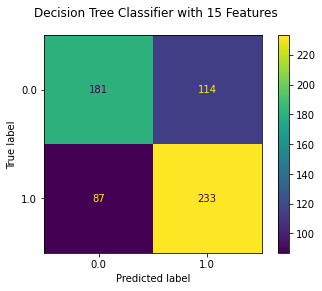

In [58]:
fig, ax = plt.subplots()
fig.suptitle("Decision Tree Classifier with 15 Features")
plot_confusion_matrix(tree15_clf, X_test, y_test, ax=ax, values_format='');








Looks like the recall score is slightly worse than the simple regression, but let's take a look at exactly what these 15 features are doing behind the scenes.

In [59]:
feat15_import = {name: score 
                   for name, score 
                       in zip(X_train.columns, tree15_clf.feature_importances_)
}
feat15_import

{'follow': 0.0,
 'reg1': 0.0,
 'votemail1a': 0.0,
 'votecount': 0.0,
 'votemail2': 0.0,
 'voterid1': 0.0,
 'voterid2': 0.0,
 'turnout16a': 0.0,
 'turnout16a1': 0.0,
 'turnout16b': 0.0,
 'vote16': 0.0,
 'hopeful': 0.0,
 'afraid': 0.0,
 'outraged': 0.03200615328554915,
 'angry': 0.0,
 'happy': 0.0,
 'worried': 0.0,
 'proud': 0.0,
 'irritated': 0.0,
 'nervous': 0.0,
 'meeting': 0.0,
 'moneyorg': 0.0,
 'protest': 0.0,
 'online': 0.0,
 'persuade': 0.0,
 'button': 0.0,
 'moneycand': 0.0,
 'argument': 0.0,
 'particip_none': 0.0,
 'talk1': 0.0,
 'talk2': 0.0,
 'talk3': 0.0,
 'fttrump1': 0.0,
 'ftobama1': 0.0,
 'ftbiden1': 0.0,
 'ftwarren1': 0.0,
 'ftsanders1': 0.0,
 'ftbuttigieg1': 0.0,
 'ftharris1': 0.0,
 'ftklobuchar1': 0.0,
 'ftpence1': 0.0,
 'ftyang1': 0.0,
 'ftpelosi1': 0.0,
 'ftrubio1': 0.0,
 'ftocasioc1': 0.0,
 'fthaley1': 0.0,
 'ftthomas1': 0.0,
 'ftfauci1': 0.07541729374349332,
 'ftblack': 0.0,
 'ftwhite': 0.0,
 'fthisp': 0.0,
 'ftasian': 0.0,
 'ftillegal': 0.0,
 'ftfeminists': 0.0,
 

Let's take the top 5 features from this decision tree, then SMOTE the data to account for any imbalance, then run a logistic regression on top of that.

# Model 4: SMOTE Logistic Regression with Top 5 From Top 15

In [60]:
dt_5 = data_clean[['immpres7', 'viol1', 'conf_covid2', 'votemail2', 'whitejob', 'covid_mis_score']]

In [61]:
#train test split
X = dt_5.drop(['covid_mis_score'],axis=1)
y = dt_5['covid_mis_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)


In [62]:
#smote
from imblearn.over_sampling import SMOTE, ADASYN
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

[(0.0, 1577), (1.0, 1577)]


In [63]:
# logistic regression after smote 

scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train)
X_test_scaled = scale.transform(X_test)



smote_log = LogisticRegression(random_state=42)
smote_log.fit(X_train_scaled, y_train )

LogisticRegression(random_state=42)

In [64]:
y_pred_train = smote_log.predict(X_train_scaled)
y_pred_test = smote_log.predict(X_test_scaled)

print(f"Train Recall Score: {recall_score(y_train, y_pred_train, average='weighted')}")
print(f"Test Recall Score: {recall_score(y_test, y_pred_test, average='weighted')}")

Train Recall Score: 0.6914936914936914
Test Recall Score: 0.6861788617886179


We're doing better than model 3! Increased recall by 0.05. But still have not improved from Model 2.

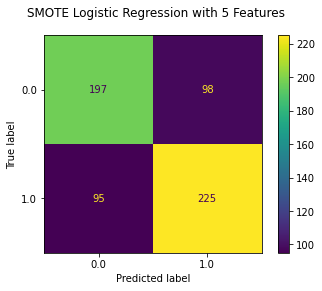

In [65]:
fig, ax = plt.subplots()
fig.suptitle("SMOTE Logistic Regression with 5 Features")
plot_confusion_matrix(smote_log, X_test_scaled, y_test, ax=ax, values_format='');

Since logistic seems to be doing the best, why don't we try a plain logistic regression with those 15 features, so we can see if SMOTE or the feature importance was doing anything worthwhile.

# Model 5: Logistic with Top 15

In [66]:


X = features15.drop(['covid_mis_score'], axis=1)
y = features15['covid_mis_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)


scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train)
X_test_scaled = scale.transform(X_test)



features_log = LogisticRegression(random_state=42)
features_log.fit(X_train_scaled, y_train )

LogisticRegression(random_state=42)

In [67]:
y_pred_train = features_log.predict(X_train_scaled)
y_pred_test = features_log.predict(X_test_scaled)

print(f"Train Recall Score: {recall_score(y_train, y_pred_train, average='weighted')}")
print(f"Test Recall Score: {recall_score(y_test, y_pred_test, average='weighted')}")

Train Recall Score: 0.7175417175417176
Test Recall Score: 0.6894308943089431


Looks like this simple logistic regression increased recall by 0.002 from Model 2!


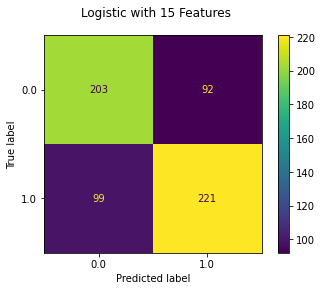

In [68]:
fig, ax = plt.subplots()
fig.suptitle("Logistic with 15 Features")
plot_confusion_matrix(features_log, X_test_scaled, y_test, ax=ax, values_format='');

Let's try a GridSearchCV to find the best parameters possible.

# Model 6: Logistic with Top 15 & GridSsearchCV

In [69]:
X = features15.drop(['covid_mis_score'], axis=1)
y = features15['covid_mis_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)


scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train)
X_test_scaled = scale.transform(X_test)

In [70]:
log_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [1e-3, 1e-1, 1e2, 1e4, 1e6],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'class_weight': ['balanced', None]
}

In [71]:
grid_search_log = GridSearchCV(features_log, log_grid, cv=3)
grid_search_log.fit(X_train_scaled, y_train)

print("The best parameter combinations for the features_log model that the GridSearch found are:")
      
grid_search_log.best_params_

The best parameter combinations for the features_log model that the GridSearch found are:


{'C': 0.1, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'}

In [72]:
features_grid_model = LogisticRegression(random_state=42, C=0.100, class_weight= None, 
                                         penalty='l1', solver='saga')
features_grid_model.fit(X_train_scaled, y_train )

LogisticRegression(C=0.1, penalty='l1', random_state=42, solver='saga')

In [73]:
y_pred_train = features_grid_model.predict(X_train_scaled)
y_pred_test = features_grid_model.predict(X_test_scaled)

print(f"Train Recall Score: {recall_score(y_train, y_pred_train, average='weighted')}")
print(f"Test Recall Score: {recall_score(y_test, y_pred_test, average='weighted')}")

Train Recall Score: 0.7167277167277167
Test Recall Score: 0.6991869918699187


A small improvement from the logistic regression (Model 6)! But there are still other options we have not yet explored. Let's try a Random Forest next.

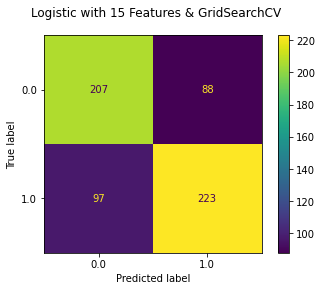

In [74]:
fig, ax = plt.subplots()
fig.suptitle("Logistic with 15 Features & GridSearchCV")
plot_confusion_matrix(features_grid_model, X_test_scaled, y_test, ax=ax, values_format='');




# Model 7: Random Forest with Top 15

In [75]:
X = features15.drop(['covid_mis_score'], axis=1)
y = features15['covid_mis_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)


scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train)
X_test_scaled = scale.transform(X_test)

In [76]:
rfc = RandomForestClassifier(random_state=42)

In [77]:
rfc.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

Recall score: 0.6764227642276422
              precision    recall  f1-score   support

         0.0       0.66      0.67      0.66       295
         1.0       0.69      0.68      0.69       320

    accuracy                           0.68       615
   macro avg       0.68      0.68      0.68       615
weighted avg       0.68      0.68      0.68       615



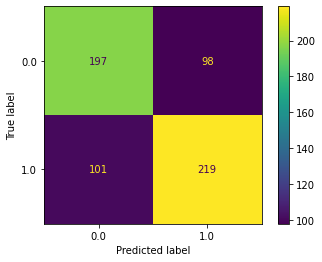

In [78]:
y_pred_rfc = rfc.predict(X_test_scaled)

recall_rfc = recall_score(y_test, y_pred_rfc, average='weighted')
print(f"Recall score: {recall_rfc}")
# Confusion matrix and classification report
print(classification_report(y_test, y_pred_rfc));
print(plot_confusion_matrix(rfc, X_test_scaled, y_test));

Looks like that did slightly worse than our logistic grid search, let's try a grid search for this random forest

# Model 8: Random Forest on Top 15 and GridSearchCV

In [79]:
rfc_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,10],
    'criterion' :['gini', 'entropy']
}

In [80]:
grid_rfc = GridSearchCV(rfc, rfc_grid, cv=3)
grid_rfc.fit(X_train_scaled, y_train)
print("Best Parameters for random forest:")
grid_rfc.best_params_

Best Parameters for random forest:


{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'n_estimators': 200}

In [81]:
best_rfc = RandomForestClassifier(random_state=42, criterion = 'gini', max_depth=10,
                                  max_features='auto', n_estimators = 200)

best_rfc.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42)

In [82]:
# Predictions on test
y_pred_rfc_grid = best_rfc.predict(X_test_scaled)

# Recall Score
recall_rfc_grid = recall_score(y_test, y_pred_rfc_grid, average='weighted')
print(f"Recall score: {recall_rfc_grid}")



Recall score: 0.697560975609756


Still not as great as that logistic regression from earlier (model 6)...

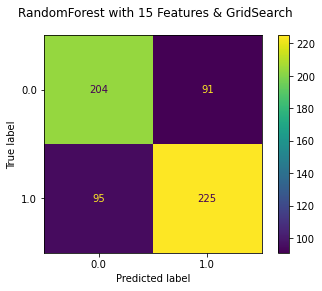

In [83]:
fig, ax = plt.subplots()
fig.suptitle("RandomForest with 15 Features & GridSearch")

plot_confusion_matrix(best_rfc, X_test_scaled, y_test, ax=ax, values_format='');

I'd still like to see if we can increase the recall score, I have not yet exhausted all my options! Let's go back to the feature selections and pick the features that show up both 4 and 5 times and run some models with those features

In [84]:
feature_selection_df.head(num_feats)

,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,Total
1,whitejob,True,True,True,True,True,5
2,votemail2,True,True,True,True,True,5
3,viol1,True,True,True,True,True,5
4,taxecon,True,True,True,True,True,5
5,talk3,True,True,True,True,True,5
6,talk2,True,True,True,True,True,5
7,return,True,True,True,True,True,5
8,lcself,True,True,True,True,True,5
9,impeach2,True,True,True,True,True,5
10,immpres7,True,True,True,True,True,5


In [85]:
more_features = data_clean[['whitejob', 'votemail2', 'viol1', 'taxecon', 'talk3', 'talk2', 'return', 'lcself', 'impeach2', 'immpres7', 'experts', 'excessive', 'econnow', 'conf_covid2', 
                            'abort1', 'viol2a', 'speech1', 'rr_scale', 'rr1', 'knowtran2_1', 'impact8', 'hopeful', 'ftpence1', 
                            'ftobama1', 'exphelp', 'econpres7', 'dtleader2', 'callout_social','covid_mis_score']]



In [86]:
#setting up train test split for the following models 
X = more_features.drop(['covid_mis_score'], axis=1)
y = more_features['covid_mis_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)


scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train)
X_test_scaled = scale.transform(X_test)

# Model 9: Random Forest with 28 Features

In [87]:
rfc_more = RandomForestClassifier(random_state=42)
rfc_more.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

Recall score: 0.6878048780487804
              precision    recall  f1-score   support

         0.0       0.67      0.68      0.68       295
         1.0       0.70      0.69      0.70       320

    accuracy                           0.69       615
   macro avg       0.69      0.69      0.69       615
weighted avg       0.69      0.69      0.69       615



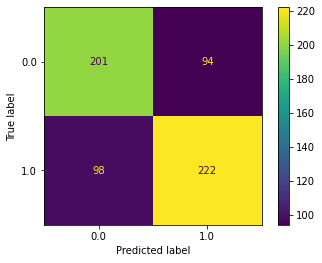

In [88]:
y_pred_rfc = rfc_more.predict(X_test_scaled)

recall_rfc = recall_score(y_test, y_pred_rfc, average='weighted')
print(f"Recall score: {recall_rfc}")
# Confusion matrix and classification report
print(classification_report(y_test, y_pred_rfc));
print(plot_confusion_matrix(rfc_more, X_test_scaled, y_test));

Again, looks like that logistic regression is still marginally better. Let's GridSearchCV on Model 5 and see if we can get a better recall score than Model 6

# Model 10: Random Forest with 28 Features & GridSearchCV

In [89]:
rfc_grid_more = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,10],
    'criterion' :['gini', 'entropy']
}

In [90]:
grid_rfc_more = GridSearchCV(rfc_more, rfc_grid_more, cv=3)
grid_rfc_more.fit(X_train_scaled, y_train)
print("Best Parameters for random forest:")
grid_rfc_more.best_params_

Best Parameters for random forest:


{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 200}

In [91]:
best_rfc_more = RandomForestClassifier(random_state=42, criterion = 'gini', max_depth=8,
                                  max_features='auto', n_estimators = 200)

best_rfc_more.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=8, n_estimators=200, random_state=42)

In [92]:
# Predictions on test
y_pred_rfc_grid_more = best_rfc_more.predict(X_test_scaled)

# Recall Score
recall_rfc_grid_more = recall_score(y_test, y_pred_rfc_grid_more, average='weighted')
print(f"Recall score: {recall_rfc_grid_more}")

#best model so far!!

Recall score: 0.7121951219512195


Model 10's recall score is better than Model 6! We went from about .69 to .71!

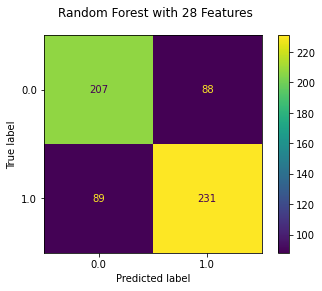

In [93]:
fig, ax = plt.subplots()
fig.suptitle("Random Forest with 28 Features")
plot_confusion_matrix(best_rfc_more, X_test_scaled, y_test, ax=ax, values_format='');

Let's take a look which features are doing the heavy lifting here 

In [94]:
feature_importances =  grid_rfc_more.best_estimator_.feature_importances_

In [95]:
hd = list(X.columns)
for i, f in zip(hd, grid_rfc_more.best_estimator_.feature_importances_):
        print(i,round(f*100,2))

whitejob 5.29
votemail2 4.87
viol1 3.75
taxecon 2.47
talk3 2.34
talk2 2.72
return 3.73
lcself 3.04
impeach2 2.81
immpres7 6.47
experts 4.35
excessive 3.88
econnow 4.81
conf_covid2 6.77
abort1 4.03
viol2a 2.17
speech1 2.38
rr_scale 4.91
rr1 2.78
knowtran2_1 0.72
impact8 3.41
hopeful 2.02
ftpence1 4.24
ftobama1 5.13
exphelp 2.2
econpres7 3.8
dtleader2 2.82
callout_social 2.07


So whitejob, immpres7, ftobama1, rr_scale are the four most important feaatures in predicting a respondent's covid misinformation score. But I wonder if any of the demographic variables are imporant... Let's look into that by creating a dataframe of just those demographic variables and then modeling the importance of those features

In [96]:
dem_df = data_clean[['age', 'sex', 'educ', 'inc_anes', 'race7', 'pid7', 'lcself', 'covid_mis_score']]

# Demographic Model 1: Decision Tree

In [97]:
X = dem_df.drop(['covid_mis_score'], axis=1)
y = dem_df['covid_mis_score']



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)



In [98]:
dem_clf = DecisionTreeClassifier(max_depth=4, random_state=42)
dem_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

In [99]:
dem_import = {name: score 
                   for name, score 
                       in zip(X_train.columns, dem_clf.feature_importances_)
}
dem_import

{'age': 0.347631130086256,
 'sex': 0.0,
 'educ': 0.01925507147249487,
 'inc_anes': 0.0,
 'race7': 0.13248055466660252,
 'pid7': 0.3075651700740781,
 'lcself': 0.19306807370056847}

So the most important demographic variables were age and party identification on the 7-item scale. Let's investigate these findings visually.

# Visualizations of Findings

Text(0.5, 1.0, 'Age vs Misinformation')

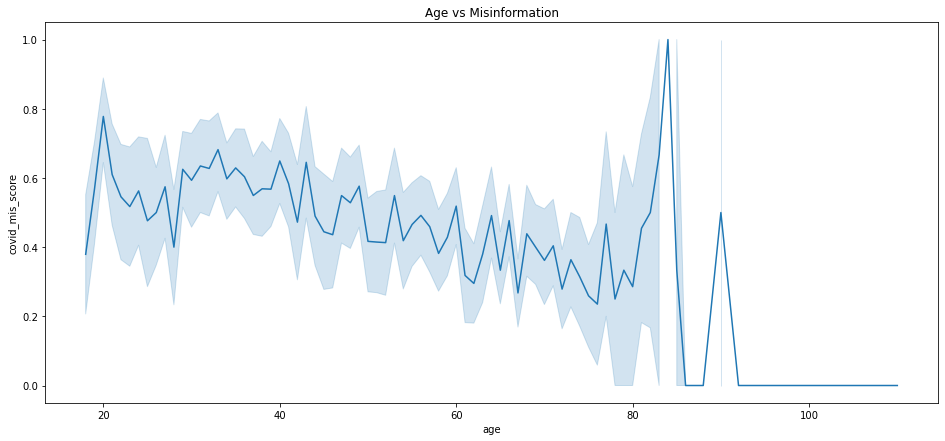

In [100]:
#covid misinf. score and age 
plt.figure(figsize=(16,7))
sns.lineplot(data=data_clean, y=data_clean['covid_mis_score'], x=data_clean['age'])
plt.title("Age vs Misinformation")
#seems like older folks are more misinformed 

<AxesSubplot:xlabel='count', ylabel='pid7'>

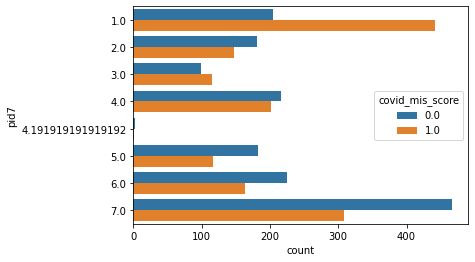

In [101]:
#party id
sns.countplot(data=data_clean, y="pid7", hue="covid_mis_score")

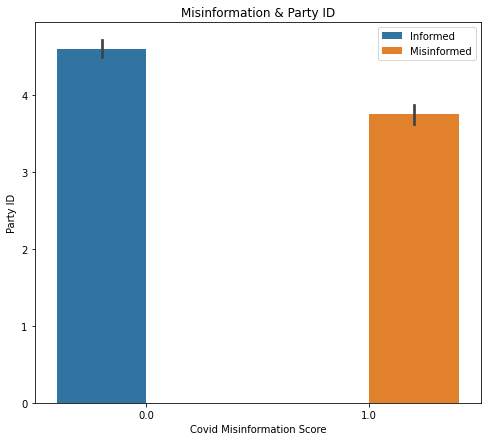

In [102]:
#pid
plt.figure(figsize=(8,7))
ax = sns.barplot(x = 'covid_mis_score', y = 'pid7', 
              data = data_clean, 
              hue = 'covid_mis_score')
ax.set(xlabel='Covid Misinformation Score', ylabel='Party ID')
plt.title("Misinformation & Party ID")
hands, labs = ax.get_legend_handles_labels()
plt.legend(handles=hands, labels=["Informed","Misinformed"])
plt.show()
#a line plot might show this relatiionship a bit better 

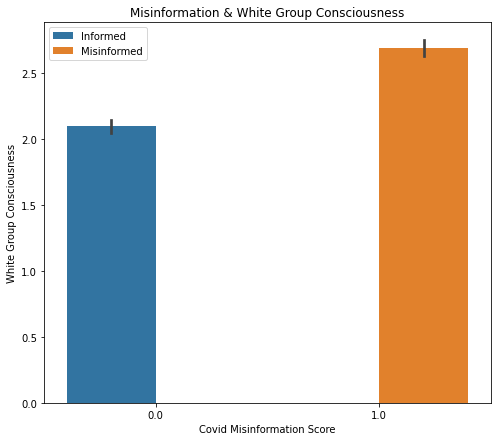

In [103]:
#white job
plt.figure(figsize=(8,7))
ax = sns.barplot(x = 'covid_mis_score', y = 'whitejob', 
              data = data_clean, 
              hue = 'covid_mis_score')
ax.set(xlabel='Covid Misinformation Score', ylabel='White Group Consciousness')
plt.title("Misinformation & White Group Consciousness")
hands, labs = ax.get_legend_handles_labels()
plt.legend(handles=hands, labels=["Informed","Misinformed"])
plt.show()
#a line plot might show this relatiionship a bit better 

Text(0.5, 1.0, 'Misinformation & White Group Consciousness')

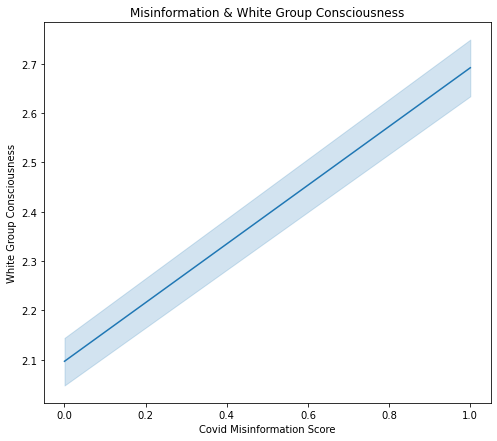

In [104]:
# that is a better viz
plt.figure(figsize=(8,7))
ax = sns.lineplot(data=data_clean, y=data_clean['whitejob'], x=data_clean['covid_mis_score'])
ax.set(xlabel='Covid Misinformation Score', ylabel='White Group Consciousness')
plt.title("Misinformation & White Group Consciousness")

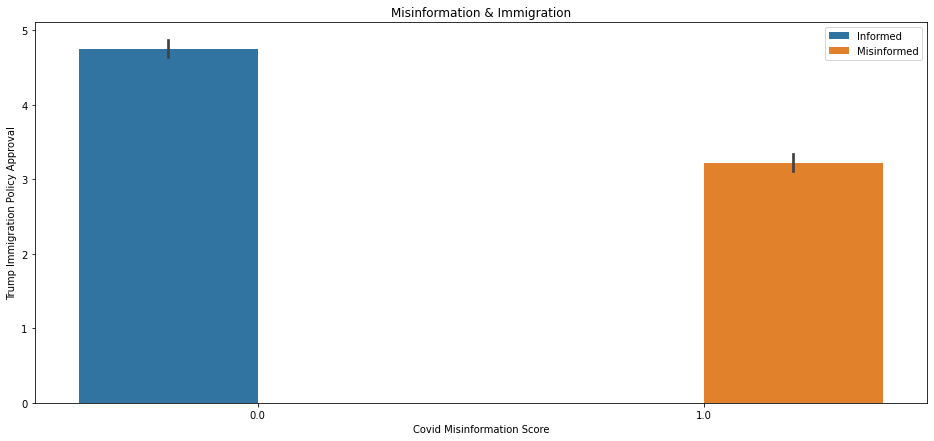

In [105]:
# immigration 
plt.figure(figsize=(16,7))
ax = sns.barplot(x = 'covid_mis_score', y = 'immpres7', 
              data = data_clean, 
              hue = 'covid_mis_score')
ax.set(xlabel='Covid Misinformation Score', ylabel='Trump Immigration Policy Approval')
plt.title("Misinformation & Immigration")
plt.legend(handles=hands, labels=["Informed","Misinformed"])
plt.show()

Text(0.5, 1.0, 'Misinformation & Trump Immigration Policy Approval')

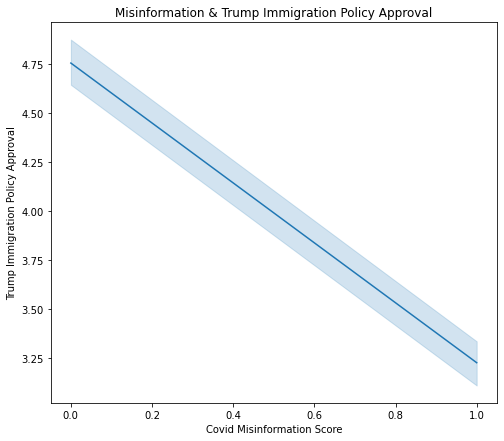

In [106]:
#immigration line plot
plt.figure(figsize=(8,7))
ax = sns.lineplot(data=data_clean, y=data_clean['immpres7'], x=data_clean['covid_mis_score'])
ax.set(xlabel='Covid Misinformation Score', ylabel='Trump Immigration Policy Approval')
plt.title("Misinformation & Trump Immigration Policy Approval")

Text(0.5, 1.0, 'Misinformation & Rating of President Barack Obama')

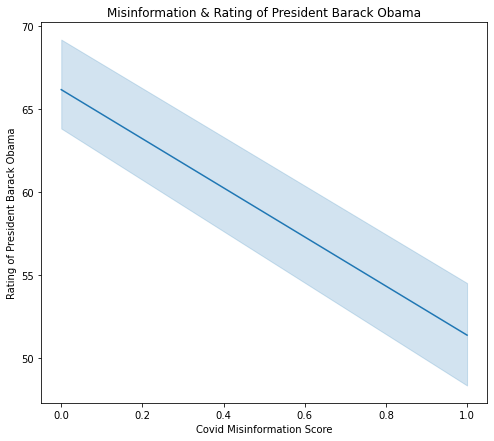

In [107]:
#obama line plot
plt.figure(figsize=(8,7))
ax = sns.lineplot(data=data_clean, y=data_clean['ftobama1'], x=data_clean['covid_mis_score'])
ax.set(xlabel='Covid Misinformation Score', ylabel='Rating of President Barack Obama')
plt.title("Misinformation & Rating of President Barack Obama")

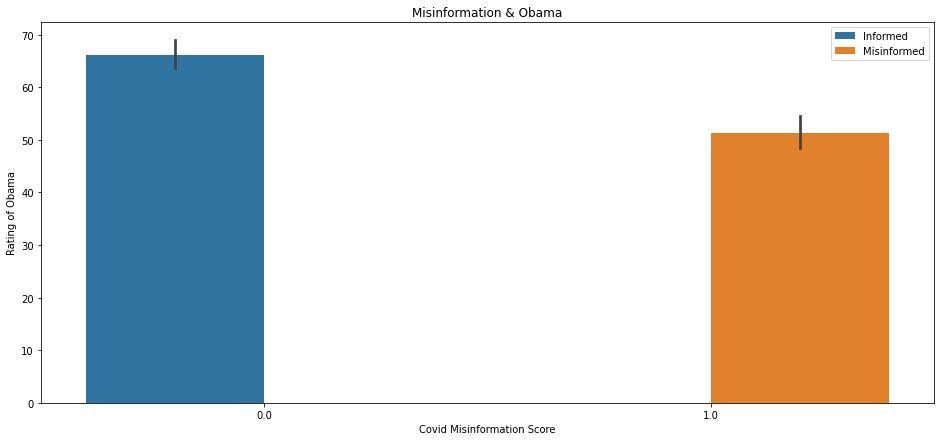

In [108]:
#obama bar plot
plt.figure(figsize=(16,7))
ax = sns.barplot(x = 'covid_mis_score', y = 'ftobama1', 
              data = data_clean, 
              hue = 'covid_mis_score')
ax.set(xlabel='Covid Misinformation Score', ylabel='Rating of Obama')
plt.title("Misinformation & Obama")
plt.legend(handles=hands, labels=["Informed","Misinformed"])
plt.show()

Text(0.5, 1.0, 'Misinformation & Racial Resentment')

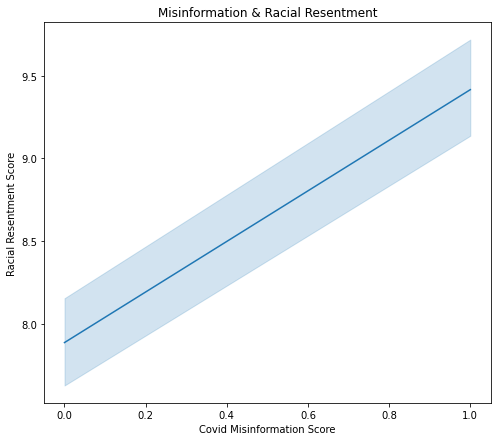

In [109]:
#rr line 
plt.figure(figsize=(8,7))
ax = sns.lineplot(data=data_clean, y=data_clean['rr_scale'], x=data_clean['covid_mis_score'])
ax.set(xlabel='Covid Misinformation Score', ylabel='Racial Resentment Score')
plt.title("Misinformation & Racial Resentment")

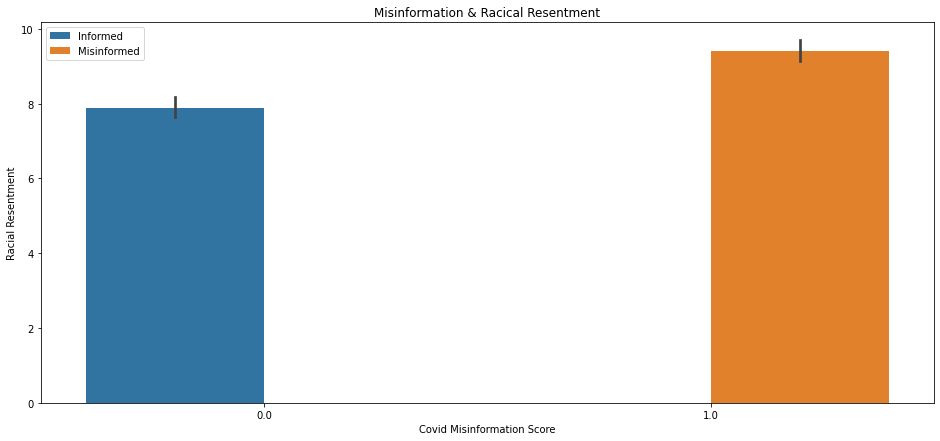

In [110]:
#rr bar
plt.figure(figsize=(16,7))
ax = sns.barplot(x = 'covid_mis_score', y = 'rr_scale', 
              data = data_clean, 
              hue = 'covid_mis_score')
ax.set(xlabel='Covid Misinformation Score', ylabel='Racial Resentment')
plt.title("Misinformation & Racical Resentment")
plt.legend(handles=hands, labels=["Informed","Misinformed"])
plt.show()

# Final Thoughts 
Model 10, the Random Forest that used 28 features in conjunction with a GridSearchCV, was the best model based off the recall score. Overall, the most important features showed that respondents with conservative leaning opinions were the most at risk for COVID-19 misinformation. This coincides with party-identification as one of the most important demographic variables.

# Disclaimer:
These findings are simply a product of the dataset. These ideas, opinions, and beliefs are not my own. Moreover, many other factors can influence misinformed viewpoints. To that end, this analysis only explores correlations NOT causations. These demographic variables and opinions may not cause one to believe in misinformation. The relationships explored in this notebook are only preliminary findings of potential relationships. This research has not been peer-reviewed, nor does it come from an accredited research instiutionn. Do not use this notebook as a source for future research projects. 